In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import ucscgenome

genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [ ]:
# bam files are in /mnt/DATA2/thouis/GM12878/     grep -l CTCF */*.json

# get the regions to use
encode_ctcf = pd.read_table('/home/kal/TF_models/data/encode_ctcf_clusteredpeaks.bed', header=None)
encode_ctcf.columns = 'chr start end name score expCount expNums expScores'.split()

shifted_db = pd.read_table('/home/kal/TF_models/data/count_regression/encode_ctcf_flankedpeaks.bed', header=None)
shifted_db.columns = 'chr start end name score expCount expNums expScores'.split()

shifted_db.name = [ n +'_shift' for n in shifted_db['name']]
both = pd.concat([shifted_db, encode_ctcf])


# write out the new data
out_columns = 'chr start end name score'.split()
both.to_csv('/home/kal/TF_models/data/count_regression/ctcf_regions.bed', 
            header=None, sep='\t', index=False, columns=out_columns)

In [15]:
# get the annotated scores

anno = pd.read_table('/home/kal/TF_models/data/count_regression/ctcf_regions_annotated_9.bed', header=None)
anno.columns = 'chr start end name score c1 c2 c3 c4 c5 c6 c7 c8 c9'.split()
#annotate the genome
half_window=256//2
for index, row in tqdm(anno.iterrows(), total=len(anno)):
    center = (row.start + row.end) // 2
    anno.set_value(index, 'nucs', genome[row.chr][(center - half_window):(center + half_window)].lower())

100%|██████████| 486627/486627 [01:03<00:00, 7719.15it/s]


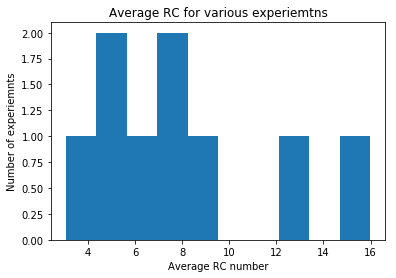

In [16]:
# get a sense of the distribution of read counts
data=list()
for i in range(1, 10):
    data.append(sum(anno['c'+str(i)])/len(anno))
plt.title('Average RC for various experiemtns')
plt.xlabel('Average RC number')
plt.ylabel('Number of experiemnts')
plt.hist(data)
plt.show()

In [17]:
# score should be log(read count/ average rc in that experiment)
for i in range(1, 10):
    anno['nlog' + str(i)] = np.log(anno['c'+str(i)]/data[i-1] +1)    
anno['read_count'] = (anno['nlog1'] + anno['nlog2'] + anno['nlog3'] + anno['nlog4'] + anno['nlog5'] + 
                      anno['nlog6'] + anno['nlog7'] + anno['nlog8'] + anno['nlog9'])/9

4.428504789088974
6.721682109706202
7.136270696036184
4.9293278013755915
12.202327449977087
3.05478323233195
8.790430863885481
15.983979516138644
7.720124448499569


In [28]:
# write out versions

out_columns = 'chr start end name score read_count nucs'.split()
anno.to_csv('/home/kal/TF_models/data/count_regression/ctcf_regions_annotated.bed', 
            header=None, sep='\t', index=False, columns=out_columns)


out_columns = 'chr start end name score nucs nlog1 nlog2 nlog3 nlog4 nlog5 nlog6 nlog7 nlog8 nlog9'.split()
anno.to_csv('/home/kal/TF_models/data/count_regression/ctcf_regions_9_log.bed', 
            header=None, sep='\t', index=False, columns=out_columns)

out_columns = 'chr start end name score nucs c1 c2 c3 c4 c5 c6 c7 c8 c9'.split()
anno.to_csv('/home/kal/TF_models/data/count_regression/ctcf_regions_9_seqs.bed', 
            header=None, sep='\t', index=False, columns=out_columns)

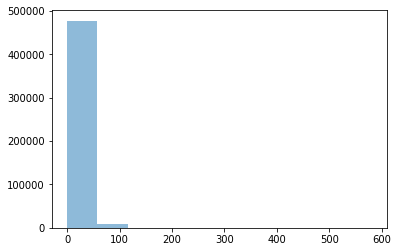

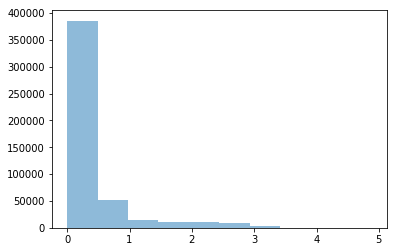

In [27]:
# learn a little more about this dataset
plt.hist(anno['c1'], alpha=0.5)
plt.show()
plt.hist(anno['nlog1'], alpha=0.5)
plt.show()